In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

## 1. Reading data

In [2]:
data = pd.read_csv("mushroom.csv")
data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


In [3]:
#по умолчанию describe делается по числовым колонкам
data.describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


In [4]:
#describe по не числовым колонкам
data.describe(exclude=[np.number])

,class,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
count,61069,61069,46949,61069,61069,51185,36006,61069,9531,22945,61069,3177,7413,61069,58598,6354,61069,61069
unique,2,7,11,12,2,7,3,12,5,8,13,1,6,2,8,7,8,4
top,p,x,t,n,f,a,c,w,s,s,w,u,w,f,f,k,d,a
freq,33888,26934,8196,24218,50479,12698,24710,18521,3177,6025,22926,3177,5474,45890,48361,2118,44209,30177


In [5]:
NaN_percent = data.isnull().sum(axis=0) / len(data) * 100 # % NaN
print(NaN_percent)

class                    0.000000
cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.121387
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         16.184971
gill-spacing            41.040462
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               84.393064
stem-surface            62.427746
stem-color               0.000000
veil-type               94.797688
veil-color              87.861272
has-ring                 0.000000
ring-type                4.046243
spore-print-color       89.595376
habitat                  0.000000
season                   0.000000
dtype: float64


* Существует проблема, что есть признаки, у которых  большое количество пропусков, поэтому для некоторых моделей это может стать проблемой

  Так как я не разбираюсь в грибах принимаю решение избавиться от тех признаков, что содержат много пропусков, а там где пропусков мало заполним модой

* Классы выглядят сбалансированными

In [6]:
data = data.drop(columns=NaN_percent[NaN_percent > 20].index) #удалим столбцы, в которых >20% значений пропущено

In [7]:
data.fillna(data.mode().to_numpy, inplace=True)

In [8]:
X, y = data.drop('class', axis=1).copy(), data['class'].copy()
print(y.describe())
print({k:(y == k).mean() for k in y.unique()})

count     61069
unique        2
top           p
freq      33888
Name: class, dtype: object
{'p': 0.5549132947976878, 'e': 0.44508670520231214}


In [9]:
#y transformation
LE = LabelEncoder().fit(y)
y = LE.transform(y)

In [10]:
#x transformation
categorical_columns = X.select_dtypes(exclude = [np.number]).columns.to_list()

for col in categorical_columns:
    oh = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
    one_hot_encoded = oh.fit_transform(X[[col]].astype(str))
    X = pd.concat([X,one_hot_encoded],axis=1).drop(columns=[col])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 2. Training models

In [12]:
models_dict = {}

#### 2.1 OneRule

In [13]:
from mlxtend.classifier import OneRClassifier

In [14]:
OneR = OneRClassifier().fit(X_train.to_numpy(), y_train)
y_pred = OneR.predict(X_test.to_numpy())
print(f'Accuracy: {(y_pred == y_test).mean()}')

Accuracy: 0.6022597019813329


In [15]:
models_dict['OneR'] = OneR

#### 2.2 LogisticRegression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
LogReg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
print(
f'''Accuracy: {LogReg.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, LogReg.predict_proba(X_test)[:, 1])}'''
)

Accuracy: 0.7713552753670652
roc_auc score 0.8384768827536154


In [18]:
models_dict['LogReg'] = LogReg

#### 2.3 KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
KNN = KNeighborsClassifier().fit(X_train, y_train)
print(
f'''Accuracy: {KNN.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, KNN.predict_proba(X_test)[:, 1])}'''
)

Accuracy: 0.9964521587249604
roc_auc score 0.9992891832357069


In [21]:
models_dict['KNN'] = KNN

#### 2.4 Bayes Classifier

In [22]:
from sklearn.naive_bayes import CategoricalNB

In [23]:
MrBayes = CategoricalNB(min_categories=X.nunique()).fit(X_train, y_train)
print(
f'''Accuracy: {MrBayes.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, MrBayes.predict_proba(X_test)[:, 1])}'''
)

Accuracy: 0.7333660826374107
roc_auc score 0.8132687019237942


In [24]:
models_dict['Bayes'] = MrBayes

#### 2.5 DescisionTree

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
tree = DecisionTreeClassifier().fit(X_train, y_train)
print(
f'''train acc {(tree.predict(X_train) == y_train).mean()}
test acc {(tree.predict(X_test) == y_test).mean()}
'''
)

train acc 1.0
test acc 0.9942142896130124



In [27]:
models_dict['tree'] = tree

#### 2.6 Boosting

In [28]:
from catboost import CatBoostClassifier, Pool

In [29]:
test_pool = Pool(X_test, y_test)

boosting = CatBoostClassifier(iterations=200,
                           depth=8,
                           learning_rate=0.001,
                           loss_function='Logloss',
                           task_type='GPU',
                           verbose=False)
# train the model
boosting.fit(X_train, y_train)
# make the prediction using the resulting model
preds_class = boosting.predict(test_pool)
preds_proba = boosting.predict_proba(test_pool)
score = boosting.score(test_pool)
print("class = ", preds_class)
print("proba = ", preds_proba)
print("score = ", score)

class =  [1 1 0 ... 1 1 0]
proba =  [[0.45140407 0.54859593]
 [0.4820328  0.5179672 ]
 [0.55480628 0.44519372]
 ...
 [0.29285391 0.70714609]
 [0.37146914 0.62853086]
 [0.50325432 0.49674568]]
score =  0.8868511544129687


In [30]:
models_dict['CatBoost'] = boosting

#### 2.7 SVC

In [31]:
from sklearn.svm import SVC

In [32]:
vector_classif = SVC().fit(X_train, y_train)
print(
f'''Accuracy: {vector_classif.score(X_test, y_test)}'''
)

Accuracy: 0.8827029092298455


In [33]:
models_dict['SVM'] = vector_classif

#### 2.8 MLP

In [34]:
from sklearn.neural_network import MLPClassifier

In [35]:
MLP = MLPClassifier().fit(X_train, y_train)
print(
f'''Accuracy: {MLP.score(X_test, y_test)}
roc_auc score {roc_auc_score(y_test, MLP.predict_proba(X_test)[:, 1])}'''
)

Accuracy: 0.9983625347961356
roc_auc score 0.99999383970034


In [36]:
models_dict['MLP'] = MLP

#### 2.9 Ensemble

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
forest = RandomForestClassifier(n_estimators=50, 
                                criterion='entropy', 
                                max_depth=30)
forest.fit(X_train, y_train)
print(
f'''train acc {(forest.predict(X_train) == y_train).mean()}
test acc {(forest.predict(X_test) == y_test).mean()}'''
)

train acc 0.999953214185459
test acc 0.9986900278369084


In [39]:
models_dict['RandomForest'] = forest 

In [40]:
#а давайте сделаем ансамбль из всех моделей и попросим их проголосовать
#кроме OneR, он приемный

answers = np.zeros(shape=(len(models_dict)-1, y_test.shape[0]))
c = 0
for name, model in models_dict.items():
    if name == 'OneR':
        continue
    answers[c] = model.predict(X_test)
    c+=1
#так как моделей 8, то можно проголсовать достаточно смешной и простой формулой, при равенстве голосов побеждает 1(ядовитый), так как лучше классифицировать грибы как ядовитые
print('Accuracy нашего собрания греков: ', ((answers.sum(axis=0) >= 4).astype(int) == y_test).mean())

Accuracy нашего собрания греков:  0.9810054036351727


## 3. Testing models

#### 3.1 Metrics

In [41]:
#accuracy
accuracy_list = list() #для df
print(f'{'Model name':13}|{'accuracy':>10}')
print('-'*25)
for name, model in models_dict.items():
    score = (model.predict(X_test.to_numpy()) == y_test).mean() if name == 'OneR' else (model.predict(X_test) == y_test).mean()
    accuracy_list.append(score)
    print(f'{name:13}|{score:>10.2f}')

Model name   |  accuracy
-------------------------
OneR         |      0.60
LogReg       |      0.77
KNN          |      1.00
Bayes        |      0.73
tree         |      0.99
CatBoost     |      0.89
SVM          |      0.88
MLP          |      1.00
RandomForest |      1.00


In [42]:
#f1-score
f1_list = list() #для df
print(f'{'Model name':13}|{'f1-score':>10}')
print('-'*25)
for name, model in models_dict.items():
    y_pred = model.predict(X_test.to_numpy()) if name == 'OneR' else model.predict(X_test)
    score = f1_score(y_test, y_pred)
    f1_list.append(score)
    print(f'{name:13}|{score:>10.2f}')

Model name   |  f1-score
-------------------------
OneR         |      0.65
LogReg       |      0.79
KNN          |      1.00
Bayes        |      0.75
tree         |      0.99
CatBoost     |      0.90
SVM          |      0.90
MLP          |      1.00
RandomForest |      1.00


In [43]:
#roc_auc_score
#Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
roc_auc_list = list() # для df
print(f'{'Model name':13}|{'f1-score':>10}')
print('-'*25)
for name, model in models_dict.items():
    if name == 'OneR':
        y_pred = model.predict(X_test.to_numpy())
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        roc_auc_list.append(roc_auc)
        print(f'{name:13}|{roc_auc:>10.2f}')
        continue

    y_score = model.decision_function(X_test) if name == 'SVM' else model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_score)
    roc_auc_list.append(score)
    print(f'{name:13}|{score:>10.2f}')

Model name   |  f1-score
-------------------------
OneR         |      0.60
LogReg       |      0.84
KNN          |      1.00
Bayes        |      0.81
tree         |      0.99
CatBoost     |      0.95
SVM          |      0.95
MLP          |      1.00
RandomForest |      1.00


In [44]:
#beautiful table
score_table = pd.DataFrame(np.array([accuracy_list, f1_list, roc_auc_list]).T, index=models_dict.keys(), columns=['Accuracy', 'F1_Score', 'ROC AUC'])
score_table

,Accuracy,F1_Score,ROC AUC
OneR,0.602260,0.646759,0.595637
LogReg,0.771355,0.793899,0.838477
KNN,0.996452,0.996770,0.999289
Bayes,0.733366,0.754115,0.813269
tree,0.994214,0.994733,0.994094
CatBoost,0.886851,0.896932,0.953978
SVM,0.882703,0.895298,0.945840
MLP,0.998363,0.998508,0.999994
RandomForest,0.998690,0.998807,0.999918


#### 3.2 Plots

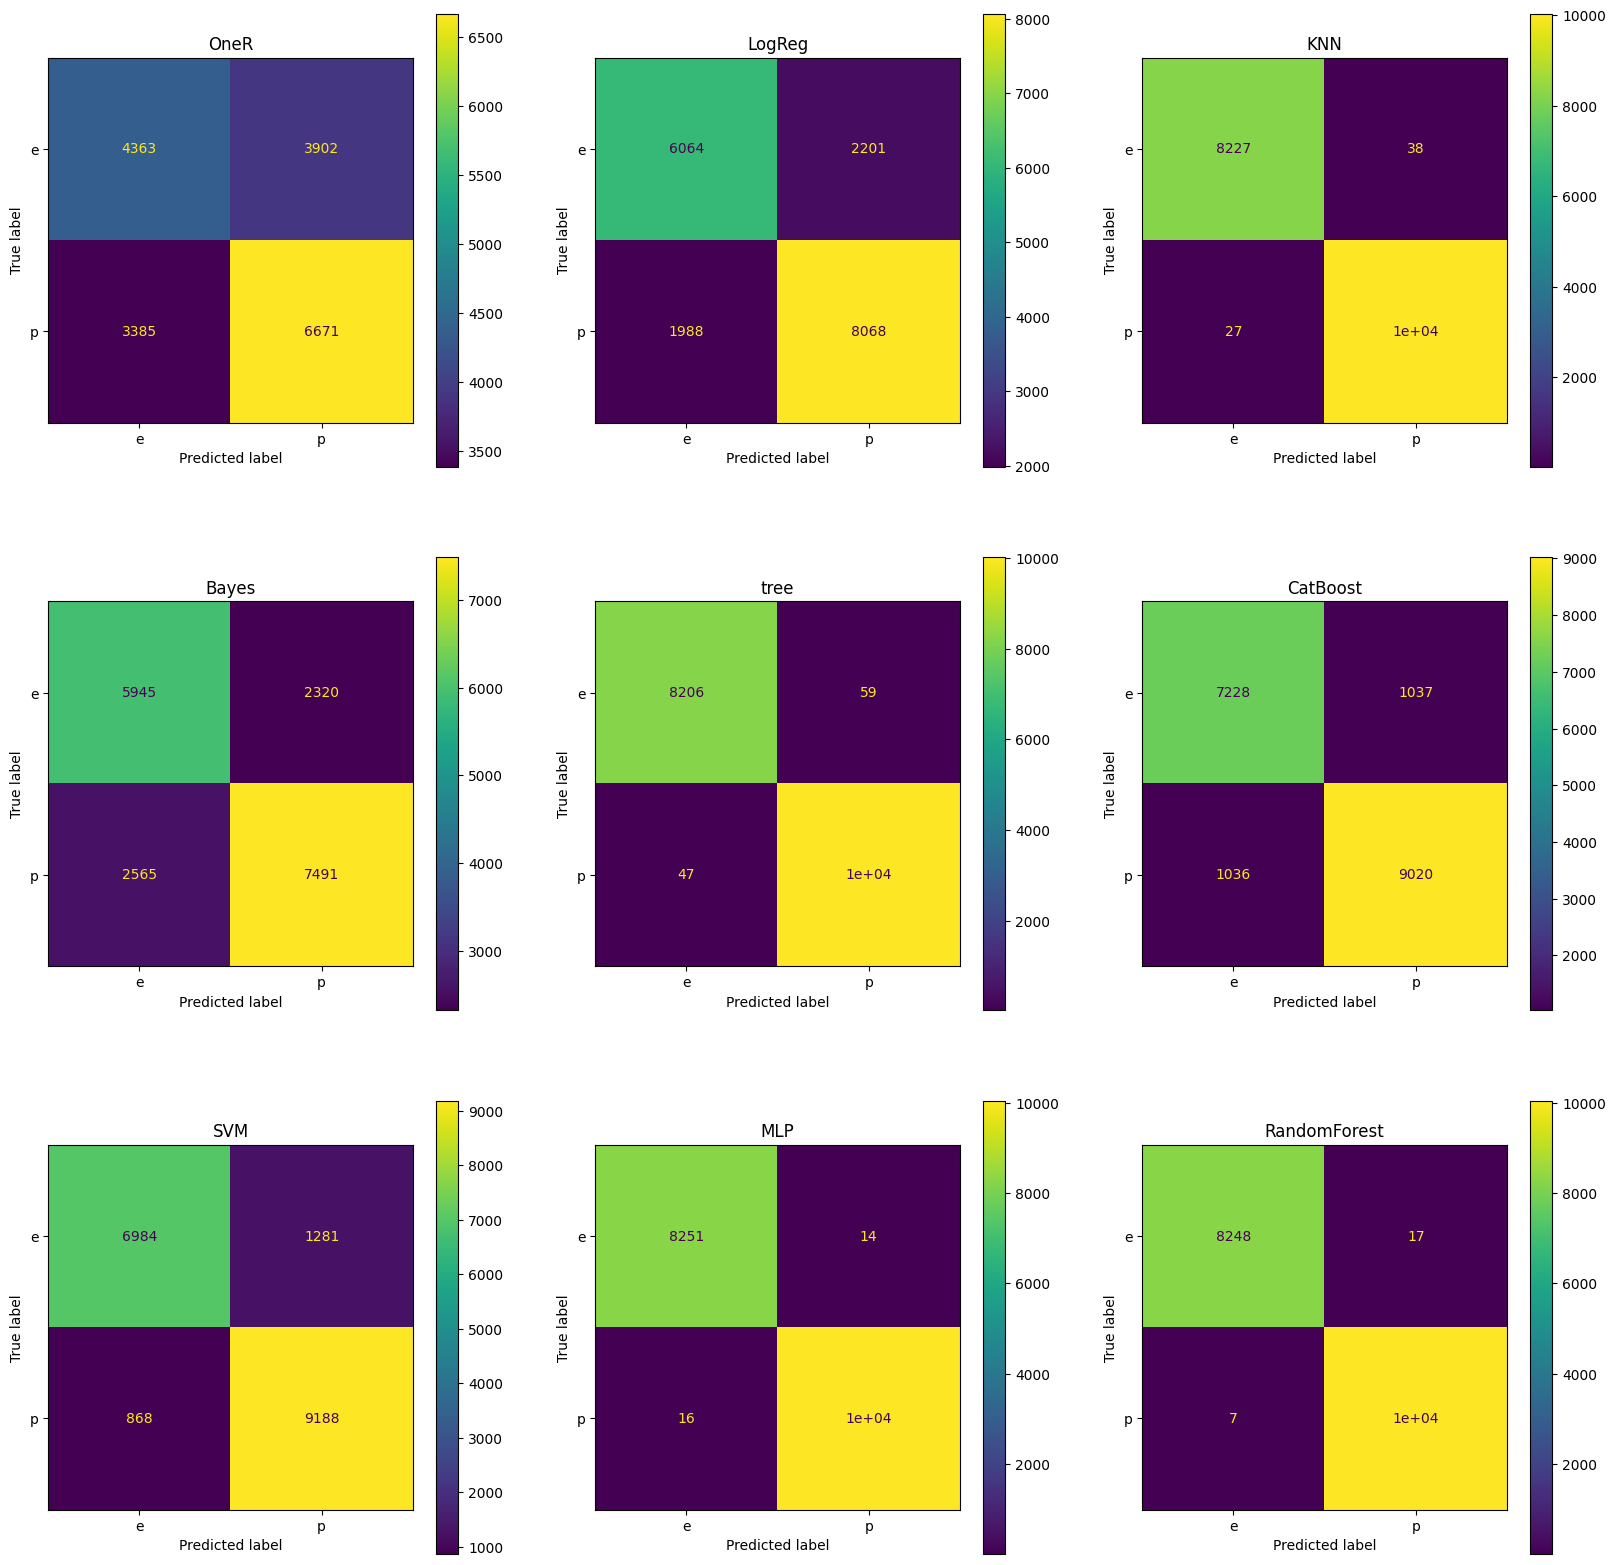

In [45]:
#confusion matrix
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
counter = 0
for i in range(3):
    for j in range(3):
        name, model = list(models_dict.items())[counter]
        y_pred = model.predict(X_test.to_numpy()) if name == 'OneR' else model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        ax[i][j].set_title(name)
        ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LE.classes_).plot(ax=ax[i][j])
        counter+=1

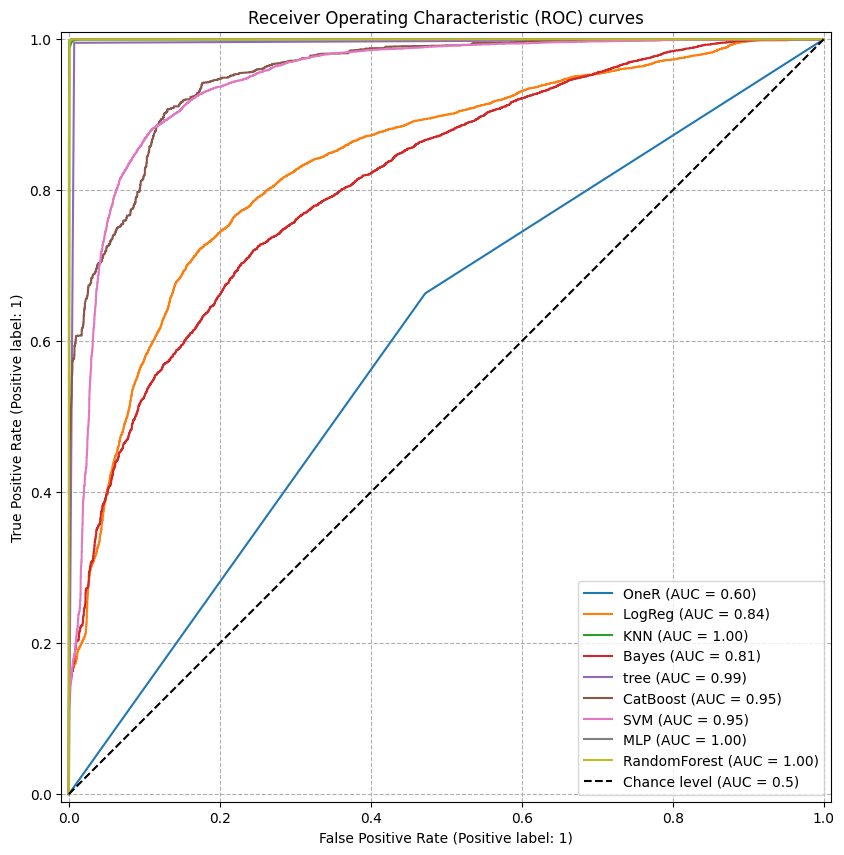

In [46]:
#roc auc curve
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for name, model in models_dict.items():
    if name == 'OneR':
        y_pred = model.predict(X_test.to_numpy())
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=name).plot(ax=ax) if name == 'OneR' else RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)
ax.plot((0, 1), (0, 1), 
        label="Chance level (AUC = 0.5)",
        color="k",
        linestyle="--",)
ax.legend()
ax.set_title("Receiver Operating Characteristic (ROC) curves")
ax.grid(linestyle="--")

## 4. Исследование важности признаков

в этой части работы мне на голову упал кокос и мне захотелось исследовать признаки кетбуста, так как он кажется черным ящиком

e - 0, p - 1

In [47]:
import catboost
import shap
from sklearn.feature_selection import RFE

/home/bob1ch/Рабочий стол/Задача 06A. Классификация табличных данных/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
cat = models_dict['CatBoost']

In [49]:
#признаки, которые являются значимыми (>5)
feature_importances_value = cat.feature_importances_[cat.feature_importances_ > 5]
feature_importances_name = np.array(cat.feature_names_)[cat.feature_importances_ > 5]
(feature_importances_name, feature_importances_value)

(array(['stem-height', 'stem-width', 'gill-attachment_a',
        'gill-attachment_d', 'gill-color_w', 'stem-color_w'], dtype='<U398'),
 array([ 7.88987006, 15.02429551,  8.00840991, 10.57249238,  7.20280658,
        20.56509551]))

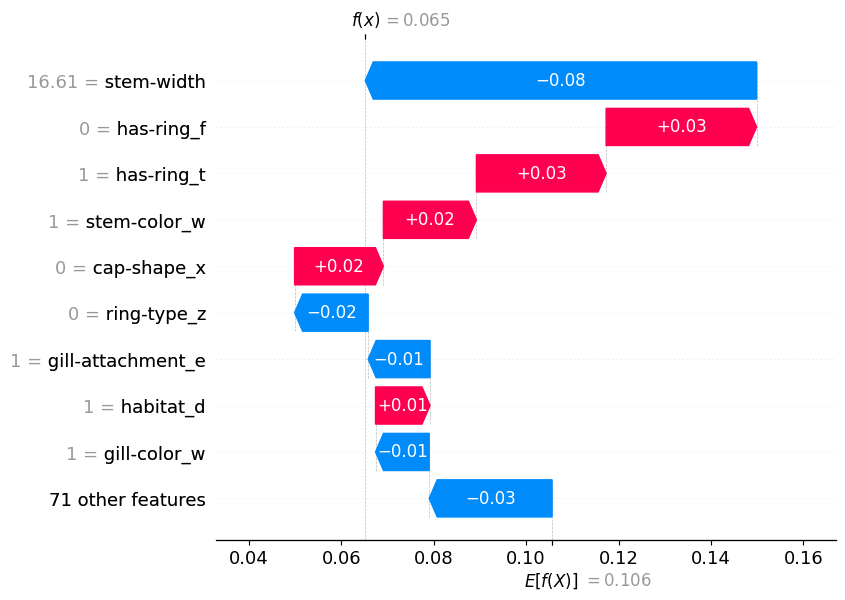

In [50]:
#посмотрим на фичи через shap
explainer = shap.Explainer(cat)
shap_values = explainer(X)

shap.plots.waterfall(shap_values[516])

* Ожидаемое прогнозируемое значение = 0.098 (с некоторой точки зрения это очень хорошо, потому что лучше классифицировать случайный гриб как ядовитый)
* Спрогнозированое значение = 0,069

Для гриба 516 получается что:
* при достаточно **широкой**(1.6 см) ножке
* её **белым** цветом
* **отсутствием** zone кольца
* Шляпкой **не в форме купола (convex)**
* **наличием** кольца в принципе (случайно получилось, что бинарный признак прогнал через OHE)
* присоединением жабр **e** (free) P.S. что-то вроде крыла, но крепится сразу к основанию шляпки(имеется в виду без дистанции)
* **белым** цветом жабр
* и произрастанием гриба в d woods, по всей видимости в деревьях, как трутовик

модель говорит, что гриб ядовитый

ширина ножки, присоединение жабр и их цвет, вид кольца и ещё 71 признак толкают наш гриб к классу ядовитых

In [51]:
LE.inverse_transform([y[516]])

array(['p'], dtype=object)

![гугл запрос ядовитый гриб на дереве](https://img.7dach.ru/image/600/00/00/00/2021/09/24/c5974e.jpg)

просто пример гриба, который немного похож по описанию

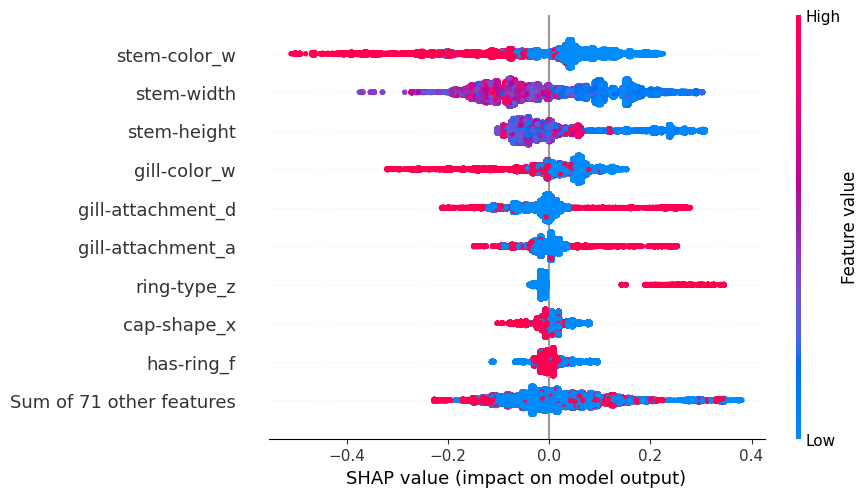

In [52]:
shap.plots.beeswarm(shap_values)

* слева - 0, справа 1, классы
* толщина линии прямо пропорциональна количеству точек наблюдения
* чем краснее точки, тем большее значение имеет признак в этой точке
* Упорядочены по дисперсии


Если у гриба белая ножка, тем он будет более **съедобныи**

с ножкой не очень хорошее разделение, но если узкая, то может быть **ядовитым**

Если ножка высокая, то может быть **съедобным**

Если жабры белые, то скорее всего **съедобный**

По креплению жабр d не очень понятно

по креплению жабр a adnate(ровныеЮ крепятся точно к стволу), то скорее всего **ядовитый**

Если кольцо есть на грибе, то тоже не очень понятно(скорее всего из-за того, что это зависит от типа кольца)

Если на кольце нет юбочки, а есть zone, то **ядовитый**

Примерный съедобный гриб: Белая, высокая, толстая ножка, жабры также белые, кольцо не zone


![боровик](https://fungiline.com/wp-content/uploads/2021/10/borovik_4-600x600.jpg)

Примерный ядовитый гриб: не белая, низкая, тонкая ножка, жабры не белые, кольцо zone

![гугл запрос самые ядовитые грибы](https://gribnik.info/wp-content/uploads/2022/07/blobid1657188933401.jpg)

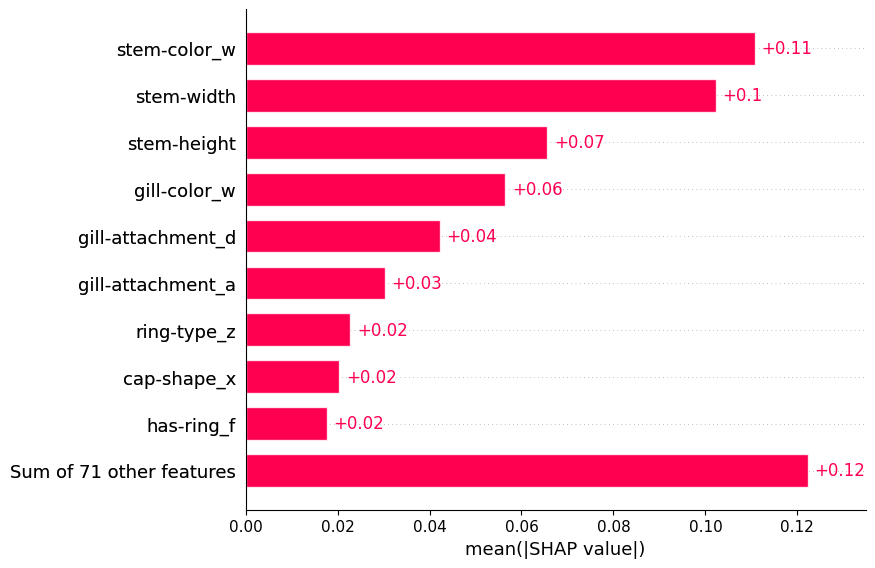

In [53]:
shap.plots.bar(shap_values)

При помощи диаграммы выше можно определить какие признаки являются являются наиболее важными для прогноза модели

## Приложение А

* stem-width - ширина ножки гриба
* stem-color - цвет ножки гриба (w - white и т.д. f - none)
* gill-spacing - расстояние между жабрами грибов в ламеле(то что под шляпкой) (close (c) distant (d) none (f))
* stem-height - высота ножки
* ring-type - вид кольца под шляпкой гриба (z - место где должно быть кольцо, там просто окрашенная зона) P.S. самый частый тип flaring - он похож на юбочку, но несмотря на то, что он самый частый, он не является значимым признаком
* cap-shape - вид шляпки гриба (b - bell, похож на колокольчик)
* stem-surface - текстура ножки (g - grooved(с бороздками), s - smooth(гладкая))
* has-ring - наличие кольца (f - none, t -есть)
* gill-attachment - то, как крепятся жабры, словами сложно это описать, но по картинке +- понятно
* gill-color - цвет жабр
* habitat - место где гриб вырос

## Приложение B

![Съедобные грибы](https://priazove.ru/wp-content/uploads/2023/10/09770ac62196e9702135d33b58e51cff.jpeg)

![Ядовитые грибы](https://wildwanderco.com/cdn/shop/products/poisonous-mushrooms-chart-28209221304418.jpg?v=1700142290)

## Заключение

Датасет меня заинтересовал тем, что в детстве с бабушкой и дедушкой я ходил за грибами, поэтому с некоторыми яъедобными грибами и некоторыми аспектами съедобности грибов я знаком

Интересно было посмотреть как математика может справиться с такой достаточно сложной задачей

Сложность задачи заключается в большом многообразии грибов и даже достаточно опытный человек скорее всего не сможет классифицировать впервые увиденный гриб

К моему счастью модели справились достаточно хорошо с этой задачей и что ещё лучше ожидаемое прогнозируемое значение - это то, что гриб ядовитый, так как лучше классифицировать съедобный гриб как ядовитый, чем ядовитый как съедобный